In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import keras.backend as K
import tensorflow as tf
import pandas as pd
import numpy as np

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 16
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## Inception

In [2]:
#transfer learning
from keras.applications.inception_v3 import InceptionV3

In [3]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

for layer in base_model.layers:
    layer.trainable=False

model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 batch_normalization_94 (Bat  (None, 6, 6, 2048)       8192      
 chNormalization)                                                
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
import time
# Record the start time of training
start_time = time.time()

In [12]:
epochs = 20

early_stopping = EarlyStopping(  
    monitor='val_loss',  
    min_delta=0.0001,  
    patience=4,  
    verbose=1,  
    mode='auto', 
    restore_best_weights=True  
)  

checkpoint = ModelCheckpoint(  
    filepath='inception_model_20epochs.h5',  
    monitor='val_loss',  
    save_best_only=True,  
    verbose=1  
)  
  
# 将回调添加到列表中  
callbacks_list = [early_stopping, checkpoint]  

#Training
inception_history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks = callbacks_list,
    validation_data=validation_generator,
    verbose = 1,
    validation_steps=nb_validation_samples // BATCH_SIZE) 

Epoch 1/20


2024-04-19 22:27:54.145536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-19 22:27:56.228382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-19 22:27:56.233470: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1ccbc9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-19 22:27:56.233543: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-19 22:27:56.244459: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-19 22:27:56.404679: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

105/105 [==============================] - ETA: 0s - loss: 2.0085 - accuracy: 0.2411
Epoch 1: val_loss improved from inf to 1.72945, saving model to inception_model_20epochs.h5


/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 52s 416ms/step - loss: 2.0085 - accuracy: 0.2411 - val_loss: 1.7294 - val_accuracy: 0.3702
Epoch 2/20
105/105 [==============================] - ETA: 0s - loss: 1.5019 - accuracy: 0.4161
Epoch 2: val_loss improved from 1.72945 to 1.21729, saving model to inception_model_20epochs.h5
105/105 [==============================] - 44s 424ms/step - loss: 1.5019 - accuracy: 0.4161 - val_loss: 1.2173 - val_accuracy: 0.5361
Epoch 3/20
105/105 [==============================] - ETA: 0s - loss: 1.2196 - accuracy: 0.5274
Epoch 3: val_loss improved from 1.21729 to 1.19989, saving model to inception_model_20epochs.h5
105/105 [==============================] - 49s 468ms/step - loss: 1.2196 - accuracy: 0.5274 - val_loss: 1.1999 - val_accuracy: 0.4567
Epoch 4/20
105/105 [==============================] - ETA: 0s - loss: 1.0131 - accuracy: 0.5988
Epoch 4: val_loss improved from 1.19989 to 0.96871, saving model to inception_model_20epochs.h5
105/105 [=============

In [13]:
# Record the training end time
end_time = time.time()

In [14]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 965.1640155315399 seconds


In [15]:
pd.DataFrame(inception_history.history)

,loss,accuracy,val_loss,val_accuracy
0,2.008535,0.241071,1.729449,0.370192
1,1.501866,0.416071,1.217291,0.536058
2,1.219558,0.527381,1.199887,0.456731
3,1.013131,0.598810,0.968710,0.615385
4,0.909690,0.656548,1.016307,0.661058
5,0.750073,0.720238,0.676607,0.747596
6,0.702417,0.748810,0.654912,0.754808
7,0.621867,0.764286,0.603353,0.769231
8,0.603653,0.786905,1.051128,0.661058
9,0.653737,0.758333,0.533581,0.793269


In [16]:
import joblib
joblib.dump(inception_history.history,'history_inception_best.pkl')
history_CNN3 = joblib.load('history_inception_best.pkl')

In [17]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.tight_layout()

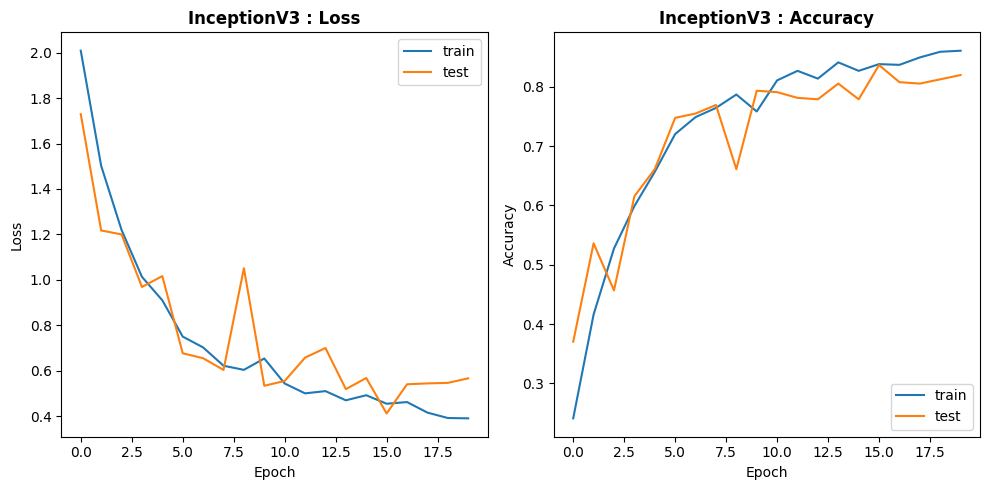

In [18]:
plot_performance(model_name='InceptionV3',
                acc=history_CNN3['accuracy'], 
                 val_acc=history_CNN3['val_accuracy'],
                 loss=history_CNN3['loss'], 
                 val_loss=history_CNN3['val_loss'])

In [19]:
# Load the best saved model
from keras.models import load_model

model_3 = load_model('inception_model_20epochs.h5')
score = model_3.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model_3.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

27/27 [==============================] - 11s 353ms/step - loss: 0.5011 - accuracy: 0.8071

Val loss: 0.5010952353477478
Val accuracy: 0.8071428537368774
33/33 [==============================] - 11s 317ms/step - loss: 0.4204 - accuracy: 0.8277

Test loss: 0.420370489358902
Test accuracy: 0.8276515007019043


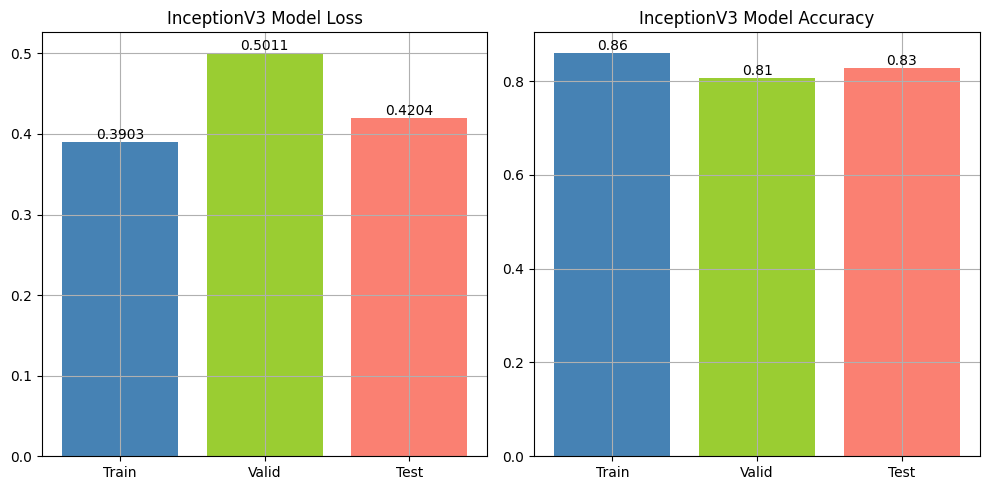

In [20]:
# Visualizing Model Performance
loss_values = [0.390253, 0.5010952353477478, 0.420370489358902]  
accuracy_values = [0.860714, 0.8071428537368774, 0.8276515007019043] 

plt.figure(figsize=(10, 5))  

plt.subplot(1, 2, 1)  
plt.title("InceptionV3 Model Loss")  
plt.bar(["Train", "Valid", "Test"], loss_values,color=['steelblue', 'yellowgreen', 'salmon'])  
  
for index, value in enumerate(loss_values):  
    plt.text(index, value, f'{value:.4f}', ha='center', va='bottom')  
  
plt.grid()  

plt.subplot(1, 2, 2)  
plt.title("InceptionV3 Model Accuracy")  
plt.bar(["Train", "Valid", "Test"], accuracy_values, color=['steelblue', 'yellowgreen', 'salmon'])  

for index, value in enumerate(accuracy_values):  
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')  
  
plt.grid()  
  

plt.tight_layout()
plt.show()

In [21]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

33/33 [==============================] - 12s 324ms/step
Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.93      0.95      0.94        88
           brown_spot       0.85      0.72      0.78        88
              healthy       0.85      0.93      0.89        88
           leaf_blast       0.80      0.75      0.77        88
           leaf_scald       0.97      0.97      0.97        88
    narrow_brown_spot       0.84      0.92      0.88        88

             accuracy                           0.87       528
            macro avg       0.87      0.87      0.87       528
         weighted avg       0.87      0.87      0.87       528



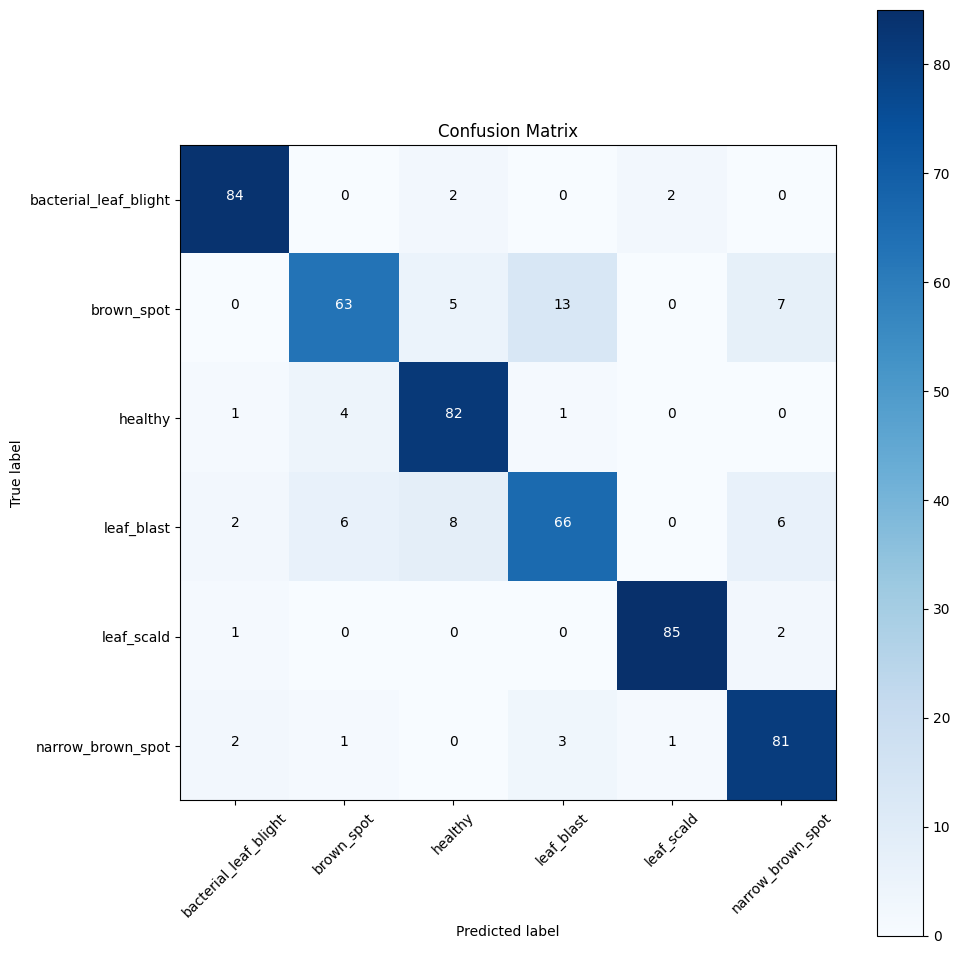

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model_3.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))


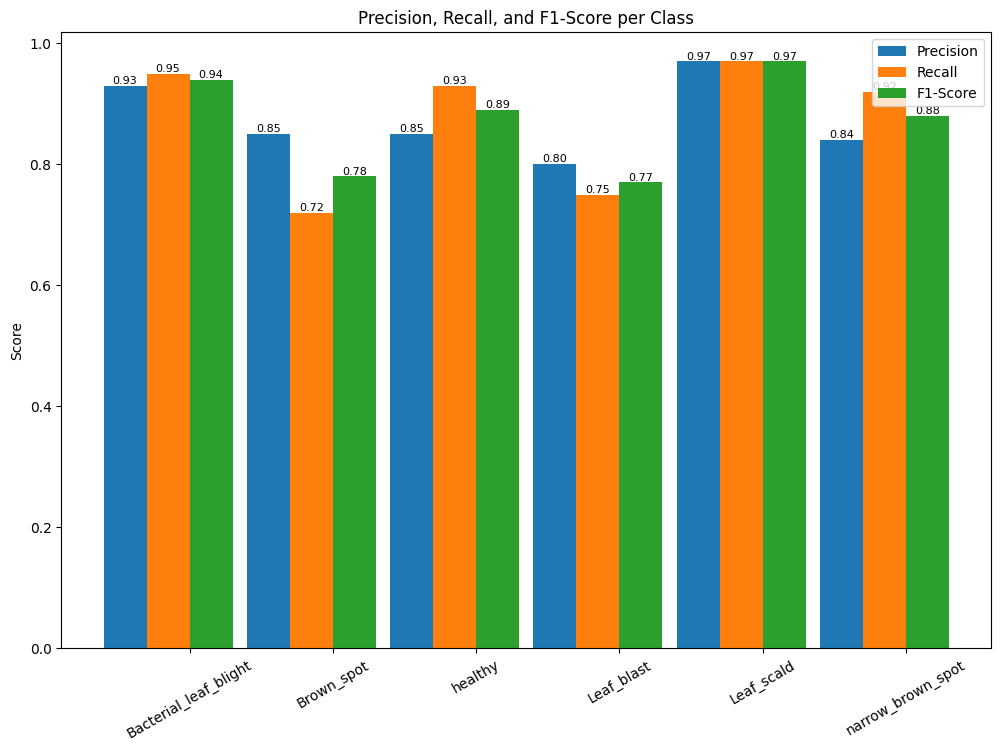

In [26]:
data = [['Bacterial_leaf_blight', 0.93, 0.95, 0.94],  
         ['Brown_spot', 0.85, 0.72, 0.78], 
         ['healthy', 0.85, 0.93, 0.89], 
         ['Leaf_blast', 0.80, 0.75, 0.77],
         ['Leaf_scald', 0.97, 0.97, 0.97],
         ['narrow_brown_spot', 0.84, 0.92, 0.88]]  
  
# 创建DataFrame  
df = pd.DataFrame(data, columns=['Classes', 'precision', 'recall', 'f1-score'])  
  
# 设置图形的宽度和位置  
N = len(df)  
ind = range(N)  
width = 0.3  # 条形图的宽度  
fig, ax = plt.subplots(figsize=(12, 8))
  
# 绘制precision的条形图  
precision_bars = plt.bar(ind, df['precision'], width, label='Precision')  
  
# 绘制recall的条形图，位置稍微偏移一点以便区分  
recall_bars = plt.bar([i + width for i in ind], df['recall'], width, label='Recall')  
  
# 绘制f1-score的条形图，再偏移一点  
f1_bars=plt.bar([i + width*2 for i in ind], df['f1-score'], width, label='F1-Score')  
  
# 添加类名到x轴  
plt.xticks([i + width*1.5 for i in ind], df['Classes'], rotation=30)  
  
# 设置y轴的标签  
plt.ylabel('Score')  
  
# 添加标题  
plt.title('Precision, Recall, and F1-Score per Class')  
  
# 添加图例  
plt.legend()  

# 为每个条形添加数字标签  
def add_value_labels(bars, fontsize=8):  
    for bar in bars:  
        height = bar.get_height()  
        plt.text(bar.get_x() + bar.get_width()/2, height,  
                 '{:.2f}'.format(height),  
                 ha='center', va='bottom', fontsize=fontsize)  
  
add_value_labels(precision_bars)  
add_value_labels(recall_bars)  
add_value_labels(f1_bars)  
  
# 显示图形  
plt.show()

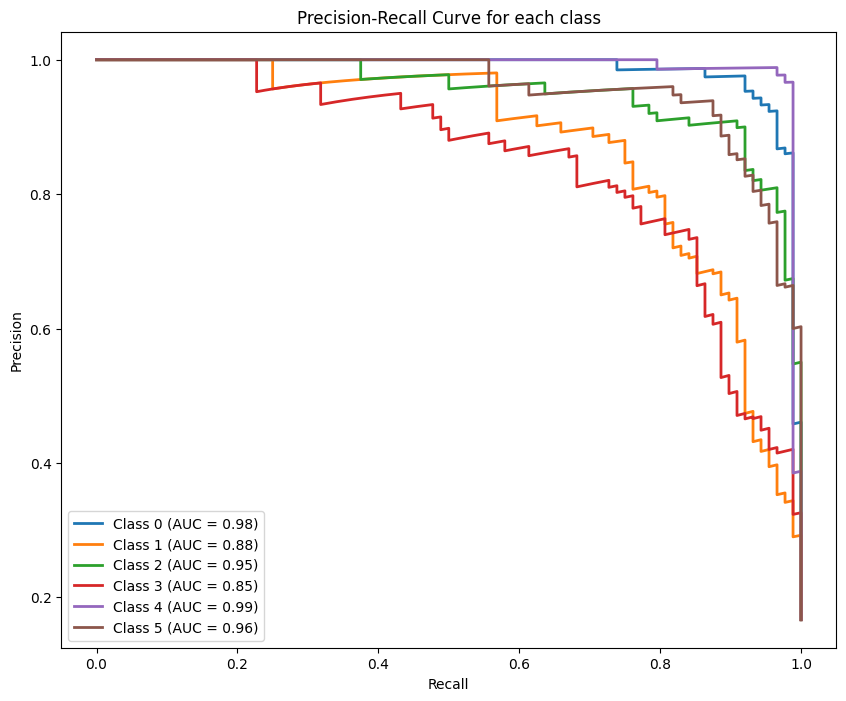

In [27]:
# Precision-Recall Curve for each class
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])
    
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend(loc="best")
plt.show()

In [28]:
#Generate predictions for the test dataset
y_pred = model_3.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

33/33 [==============================] - 10s 313ms/step


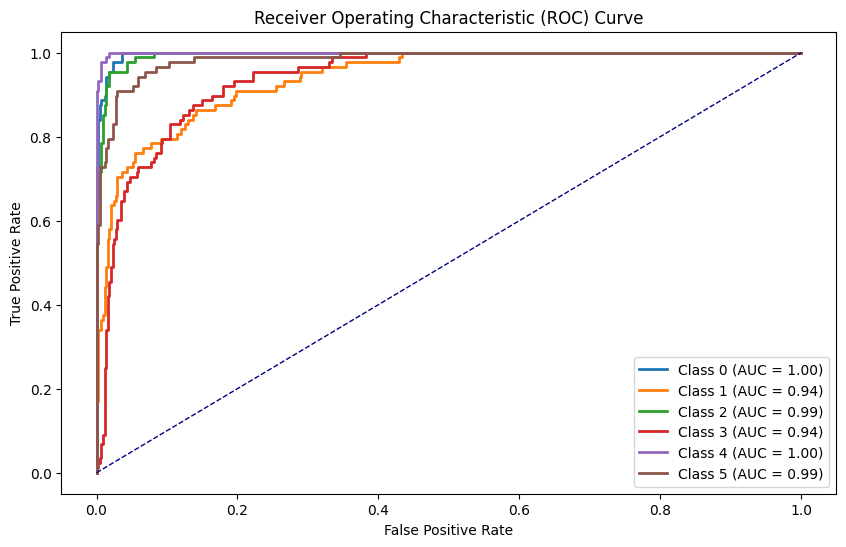

In [29]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc

#Get the true labels from thee test generator
# y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Output Sensitivity and Specificity for each category
for idx, (sen, spec) in enumerate(zip(sensitivity_list, specificity_list)):
    print(f"Class {idx} - Sensitivity: {sen}, Specificity: {spec}")

Class 0 - Sensitivity: 0.9545454545443698, Specificity: 0.9863636363634122
Class 1 - Sensitivity: 0.7159090909082774, Specificity: 0.9749999999997785
Class 2 - Sensitivity: 0.931818181817123, Specificity: 0.9659090909088714
Class 3 - Sensitivity: 0.7499999999991477, Specificity: 0.9613636363634179
Class 4 - Sensitivity: 0.9659090909079933, Specificity: 0.9931818181815925
Class 5 - Sensitivity: 0.9204545454534995, Specificity: 0.9659090909088714


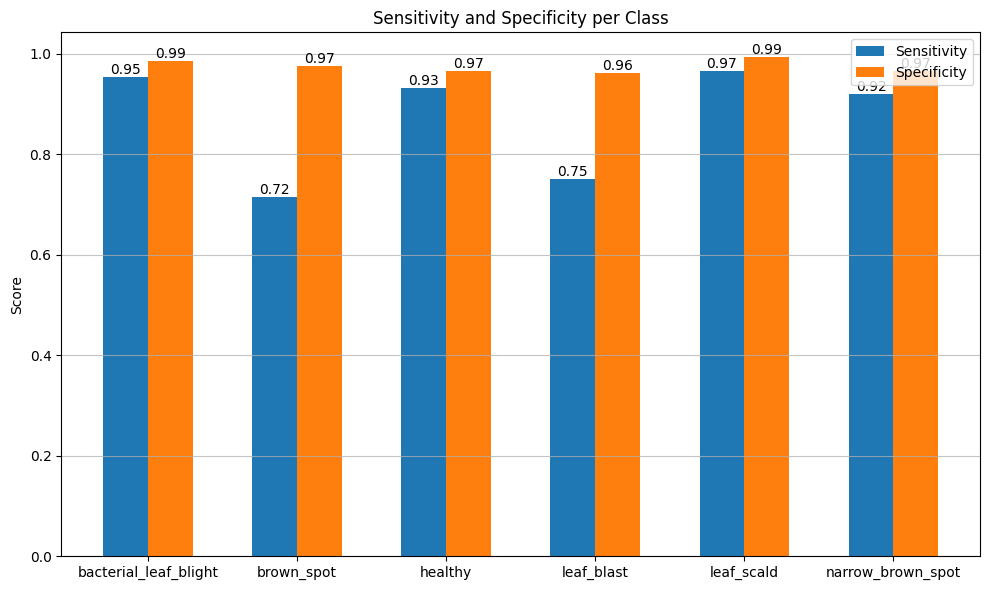

In [33]:
# 设置图形的宽度和位置  
N = len(sensitivity_list)  
ind = np.arange(N)  
width = 0.3  # 每个条形图的宽度  
  
# 绘制灵敏度的条形图  
plt.figure(figsize=(10, 6))  
sensitivity_bars = plt.bar(ind, sensitivity_list, width, label='Sensitivity')  
  
# 绘制特异度的条形图（注意：位置需要偏移以避免重叠）  
specificity_bars = plt.bar(ind + width, specificity_list, width, label='Specificity')  
   
plt.xticks(ind + width / 2, classes)  
  
# 设置x轴的标签为类别索引（如果没有具体的类标签列表）  
# plt.xticks(ind + width / 2, range(1, N + 1))  
  
# 设置y轴的标签  
plt.ylabel('Score')  
  
# 添加标题  
plt.title('Sensitivity and Specificity per Class')  
  
# 添加图例  
plt.legend()  
  
# 显示网格线  
plt.grid(axis='y', alpha=0.75)  
  
# 调整x轴和y轴的边距，以确保条形图完全可见  
plt.tight_layout()  
  
# 为每个条形添加数字标签  
def add_value_labels(bars, values):  
    for bar, value in zip(bars, values):  
        height = bar.get_height()  
        plt.text(bar.get_x() + bar.get_width() / 2, height,  
                 '{:.2f}'.format(value),  
                 ha='center', va='bottom')  
  
add_value_labels(sensitivity_bars, sensitivity_list)  
add_value_labels(specificity_bars, specificity_list)  
  
# 显示图形  
plt.show()

In [34]:
# Evaluate the performance of the model
evaluate = model_3.evaluate(
    test_generator, 
    steps = test_generator.n // BATCH_SIZE, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

33/33 [==============================] - 11s 331ms/step - loss: 0.3551 - accuracy: 0.8674
Accuracy Test : 0.8674242496490479
